In [ ]:
import pandas as pd

mchapter = pd.read_csv("mchp_relation.csv")


mchapter = mchapter.drop(columns=['성취기준코드', '성취수준 A','성취수준 B','성취수준 C','f_schapter_id','f_schapter_nm','f_tchapter_id','f_tchapter_nm','핵심키워드_v1','성취기준 내용'])

mchapter = mchapter.drop_duplicates()


94

In [15]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# KoBERT 모델과 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertModel.from_pretrained('monologg/kobert')

def get_embedding(text):
    """텍스트를 KoBERT 임베딩으로 변환"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.pooler_output  # [CLS] 임베딩
    return cls_embedding

def process_unit(title, keywords):
    """
    제목과 키워드를 각각 임베딩하고 결합
    - title: 제목 (문자열)
    - keywords: 쉼표로 구분된 핵심 키워드 문자열
    """
    # 제목 임베딩
    title_embedding = get_embedding(title)

    # 키워드 임베딩
    keyword_list = [kw.strip() for kw in keywords.split(',')] if keywords else []
    keyword_embeddings = []
    for keyword in keyword_list:
        keyword_embeddings.append(get_embedding(keyword))

    # 키워드 평균 임베딩
    if keyword_embeddings:
        keyword_embeddings = torch.stack(keyword_embeddings)  # (키워드 수, 768)
        keyword_mean_embedding = keyword_embeddings.mean(dim=0)  # (1, 768)
    else:
        keyword_mean_embedding = torch.zeros_like(title_embedding)

    # 제목과 키워드 임베딩 결합
    combined_embedding = torch.cat([title_embedding, keyword_mean_embedding], dim=1)  # (1, 1536)

    return combined_embedding

# CSV 파일 읽기
file_path = "mchaper_for_embedding.csv" 
df = pd.read_csv(file_path)

# 결과 저장 딕셔너리
embedding_dict = {}

# 데이터프레임 순회하며 임베딩 생성
for _, row in df.iterrows():
    chapter_id = row['f_mchapter_id']  # ID 컬럼
    title = row['f_mchapter_nm']  # 제목 컬럼
    keywords = row['핵심키워드_v2']  # 핵심키워드 컬럼
    combined_embedding = process_unit(title, keywords)
    embedding_dict[chapter_id] = combined_embedding.squeeze(0).numpy()  # numpy 배열로 저장

# 임베딩 결과를 .npy 파일로 저장
output_file = "mchapter_embeddings.npy"
np.save(output_file, embedding_dict)

print(f"임베딩 저장 완료: {output_file}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


임베딩 저장 완료: mchapter_embeddings.npy


In [22]:
import numpy as np

# 저장된 .npy 파일 불러오기
file_path = "mchapter_embeddings.npy"  # 저장된 파일 경로
embedding_dict = np.load(file_path, allow_pickle=True).item()

# 데이터 확인
print(f"총 임베딩 개수: {len(embedding_dict)}")

# 특정 f_mchapter_id의 임베딩 가져오기
chapter_id = 14201907  # 예: f_mchapter_id가 1인 경우
embedding = embedding_dict.get(chapter_id, None)

if embedding is not None:
    print(f"ID {chapter_id}의 임베딩 크기: {embedding.shape}")
    print(f"ID {chapter_id}의 임베딩 값:\n{embedding}")
else:
    print(f"ID {chapter_id}에 해당하는 임베딩이 없습니다.")


총 임베딩 개수: 94
ID 14201907의 임베딩 크기: (1536,)
ID 14201907의 임베딩 값:
[ 0.02019288 -0.04241268 -0.26368633 ...  0.07522373 -0.06390283
  0.03241761]


In [30]:
# 1536차 -> 94차원으로 축소

from sklearn.decomposition import PCA
import numpy as np

# 임베딩 딕셔너리 로드
embeddings_dict = np.load("mchapter_embeddings.npy", allow_pickle=True).item()

# 키와 값을 분리
f_mchapter_ids = list(embeddings_dict.keys())
embeddings = np.array(list(embeddings_dict.values()))

# PCA로 94차원으로 차원 축소
pca = PCA(n_components=94)
reduced_embeddings = pca.fit_transform(embeddings)

print(f"차원 축소된 임베딩 배열 크기: {reduced_embeddings.shape}")  # (94, 94)

# 결과 저장
output_file = "reduced_mchapter_embeddings_94.npy"
np.save(output_file, {"ids": f_mchapter_ids, "embeddings": reduced_embeddings})
print(f"차원 축소된 94차원 임베딩을 {output_file}에 저장했습니다.")



차원 축소된 임베딩 배열 크기: (94, 94)
차원 축소된 94차원 임베딩을 reduced_mchapter_embeddings_94.npy에 저장했습니다.


In [35]:
import numpy as np

# npy 파일 로드
file_path = "reduced_mchapter_embeddings_94.npy"  # 파일 경로를 적절히 수정하세요
node_features = np.load(file_path, allow_pickle=True).item()  # .item()으로 객체 추출

# 데이터 구조와 일부 데이터 출력
print("파일 데이터 타입:", type(node_features))  # 데이터 타입 확인
print("데이터의 키:", list(node_features.keys())[:5])  # 딕셔너리 키 확인
print("첫 번째 키의 데이터:", node_features[next(iter(node_features))])  # 첫 번째 값 확인


파일 데이터 타입: <class 'dict'>
데이터의 키: ['ids', 'embeddings']
첫 번째 키의 데이터: [14201779, 14201780, 14201781, 14201782, 14201783, 14201784, 14201785, 14201786, 14201787, 14201788, 14201789, 14201790, 14201791, 14201792, 14201793, 14201794, 14201795, 14201796, 14201797, 14201798, 14201799, 14201800, 14201801, 14201802, 14201803, 14201804, 14201805, 14201806, 14201807, 14201808, 14201809, 14201810, 14201811, 14201812, 14201813, 14201814, 14201815, 14201816, 14201817, 14201818, 14201819, 14201820, 14201821, 14201857, 14201858, 14201859, 14201860, 14201861, 14201862, 14201863, 14201864, 14201865, 14201866, 14201867, 14201868, 14201869, 14201870, 14201871, 14201872, 14201873, 14201874, 14201875, 14201876, 14201877, 14201878, 14201879, 14201880, 14201881, 14201882, 14201883, 14201884, 14201885, 14201886, 14201887, 14201888, 14201889, 14201890, 14201891, 14201892, 14201893, 14201894, 14201895, 14201896, 14201897, 14201898, 14201899, 14201900, 14201901, 14201902, 14201903, 14201904, 14201905, 14201906, 

In [36]:
import numpy as np

# npy 파일 로드
file_path = "reduced_mchapter_embeddings_94.npy"  # 파일 경로를 적절히 수정하세요
node_features = np.load(file_path, allow_pickle=True).item()  # .item()으로 객체 추출

# 데이터 구조와 일부 데이터 출력
print("파일 데이터 타입:", type(node_features))  # 데이터 타입 확인
print("데이터의 키:", list(node_features.keys())[:5])  # 딕셔너리 키 확인

# 첫 5개의 키와 해당 값 출력
print("\n첫 5개의 키와 데이터:")
for key in list(node_features.keys())[:5]:
    print(f"ID {key}의 임베딩: {node_features[key]}")


파일 데이터 타입: <class 'dict'>
데이터의 키: ['ids', 'embeddings']

첫 5개의 키와 데이터:
ID ids의 임베딩: [14201779, 14201780, 14201781, 14201782, 14201783, 14201784, 14201785, 14201786, 14201787, 14201788, 14201789, 14201790, 14201791, 14201792, 14201793, 14201794, 14201795, 14201796, 14201797, 14201798, 14201799, 14201800, 14201801, 14201802, 14201803, 14201804, 14201805, 14201806, 14201807, 14201808, 14201809, 14201810, 14201811, 14201812, 14201813, 14201814, 14201815, 14201816, 14201817, 14201818, 14201819, 14201820, 14201821, 14201857, 14201858, 14201859, 14201860, 14201861, 14201862, 14201863, 14201864, 14201865, 14201866, 14201867, 14201868, 14201869, 14201870, 14201871, 14201872, 14201873, 14201874, 14201875, 14201876, 14201877, 14201878, 14201879, 14201880, 14201881, 14201882, 14201883, 14201884, 14201885, 14201886, 14201887, 14201888, 14201889, 14201890, 14201891, 14201892, 14201893, 14201894, 14201895, 14201896, 14201897, 14201898, 14201899, 14201900, 14201901, 14201902, 14201903, 14201904, 14201

In [38]:
import numpy as np

# npy 파일 로드
file_path = "reduced_mchapter_embeddings_94.npy"  # 파일 경로를 적절히 수정하세요
node_features = np.load(file_path, allow_pickle=True).item()  # .item()으로 객체 추출

# 데이터 구조와 일부 데이터 출력
print("파일 데이터 타입:", type(node_features))  # 데이터 타입 확인
print("데이터의 키:", list(node_features.keys())[:5])  # 딕셔너리 키 확인

# 첫 번째 키의 임베딩 확인 및 차원 출력
first_key = next(iter(node_features))  # 첫 번째 키
embedding = node_features[first_key]  # 해당 키의 임베딩
print(f"첫 번째 키: {first_key}")
print(f"임베딩 차원: {len(embedding)}")  # 리스트 길이를 사용해 임베딩 차원 확인


파일 데이터 타입: <class 'dict'>
데이터의 키: ['ids', 'embeddings']
첫 번째 키: ids
임베딩 차원: 94


In [4]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.preprocessing import normalize

# KoBERT 모델과 토크나이저 불러오기
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertModel.from_pretrained('monologg/kobert')

def get_embedding(text):
    """텍스트를 KoBERT 임베딩으로 변환"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.pooler_output  # [CLS] 임베딩
    return cls_embedding

def process_unit(title, keywords):
    """
    제목과 키워드를 각각 임베딩하고 결합
    - title: 제목 (문자열)
    - keywords: 쉼표로 구분된 핵심 키워드 문자열
    """
    # 제목 임베딩
    title_embedding = get_embedding(title)

    # 키워드 임베딩
    keyword_list = [kw.strip() for kw in keywords.split(',')] if keywords else []
    keyword_embeddings = []
    for keyword in keyword_list:
        keyword_embeddings.append(get_embedding(keyword))

    # 키워드 평균 임베딩
    if keyword_embeddings:
        keyword_embeddings = torch.stack(keyword_embeddings)  # (키워드 수, 768)
        keyword_mean_embedding = keyword_embeddings.mean(dim=0)  # (1, 768)
    else:
        keyword_mean_embedding = torch.zeros_like(title_embedding)

    # 제목과 키워드 임베딩 결합
    combined_embedding = torch.cat([title_embedding, keyword_mean_embedding], dim=1)  # (1, 1536)

    # L2 정규화 추가
    normalized_embedding = normalize(combined_embedding.numpy(), axis=1)
    return torch.tensor(normalized_embedding)

# CSV 파일 읽기
file_path = "mchaper_for_embedding.csv" 
df = pd.read_csv(file_path)

# 결과 저장 딕셔너리
embedding_dict = {}

# 데이터프레임 순회하며 임베딩 생성
for _, row in df.iterrows():
    chapter_id = row['f_mchapter_id']  # ID 컬럼
    title = row['f_mchapter_nm']  # 제목 컬럼
    keywords = row['핵심키워드_v2']  # 핵심키워드 컬럼
    combined_embedding = process_unit(title, keywords)
    embedding_dict[chapter_id] = combined_embedding.squeeze(0).numpy()  # numpy 배열로 저장

# 임베딩 결과를 .npy 파일로 저장
output_file = "mchapter_embeddings.npy"
np.save(output_file, embedding_dict)

print(f"임베딩 저장 완료: {output_file}")


c:\Users\gganj\anaconda3\envs\pinsage\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


임베딩 저장 완료: mchapter_embeddings.npy


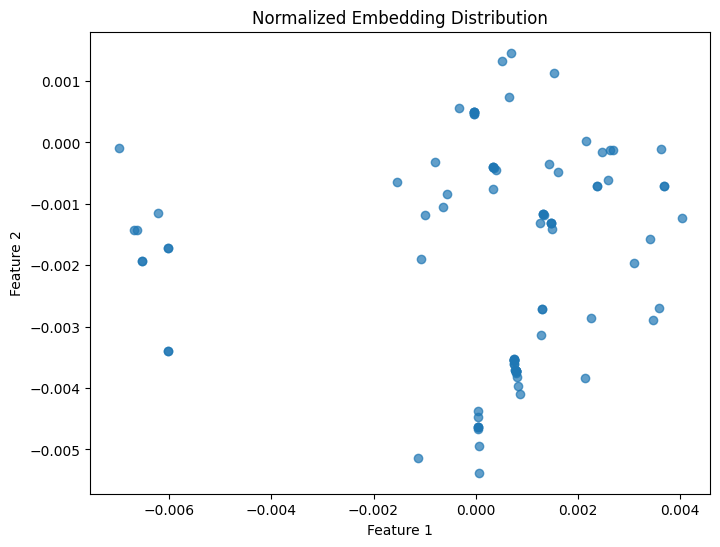

In [10]:
import matplotlib.pyplot as plt
import numpy as np 

# 임베딩 로드 및 정규화
embeddings = np.array(list(embedding_dict.values()))
normalized_embeddings = normalize(embeddings, axis=1)

# PCA 적용 전 분포 확인
plt.figure(figsize=(8, 6))
plt.scatter(normalized_embeddings[:, 0], normalized_embeddings[:, 1], alpha=0.7)
plt.title("Normalized Embedding Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


In [7]:
from sklearn.decomposition import PCA

# PCA 수행
pca = PCA(n_components=94)  # 임베딩의 차원을 최대 94로 설정
reduced_embeddings = pca.fit_transform(normalized_embeddings)

# 설명 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_


In [8]:
import numpy as np

# 누적 설명 분산 비율 계산
cumulative_variance = np.cumsum(explained_variance_ratio)


In [9]:
optimal_dimension_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"90% 이상의 누적 분산을 설명하는 차원 수: {optimal_dimension_90}")


90% 이상의 누적 분산을 설명하는 차원 수: 6


In [11]:
# 94차원을 6차원으로 축소
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import normalize

# 1. 임베딩 딕셔너리 로드
embeddings_dict = np.load("mchapter_embeddings.npy", allow_pickle=True).item()

# 2. 키와 값을 분리
f_mchapter_ids = list(embeddings_dict.keys())
embeddings = np.array(list(embeddings_dict.values()))  # (94, 1536)

# 3. 정규화 (L2 정규화)
normalized_embeddings = normalize(embeddings, axis=1)  # (94, 1536), 각 벡터를 크기 1로 정규화

# 4. 6차원으로 PCA 적용
pca = PCA(n_components=6)
final_reduced_embeddings = pca.fit_transform(normalized_embeddings)  # (94, 6)

# 5. 결과 저장
output_file = "reduced_mchapter_embeddings_6.npy"
np.save(output_file, {"ids": f_mchapter_ids, "embeddings": final_reduced_embeddings})
print(f"PCA 적용 후 6차원으로 축소된 결과를 {output_file}에 저장했습니다.")

# 6. 저장된 데이터 확인
node_features = np.load("reduced_mchapter_embeddings_6.npy", allow_pickle=True).item()
print("축소된 데이터 타입:", type(node_features))
print("데이터의 키:", node_features.keys())
print("첫 번째 중단원의 임베딩:", node_features['embeddings'][0])


PCA 적용 후 6차원으로 축소된 결과를 reduced_mchapter_embeddings_6.npy에 저장했습니다.
축소된 데이터 타입: <class 'dict'>
데이터의 키: dict_keys(['ids', 'embeddings'])
첫 번째 중단원의 임베딩: [ 0.40313062 -0.08015618 -0.08121009 -0.04983118  0.05294188 -0.05381971]


c:\Users\gganj\anaconda3\envs\pinsage\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\gganj\anaconda3\envs\pinsage\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


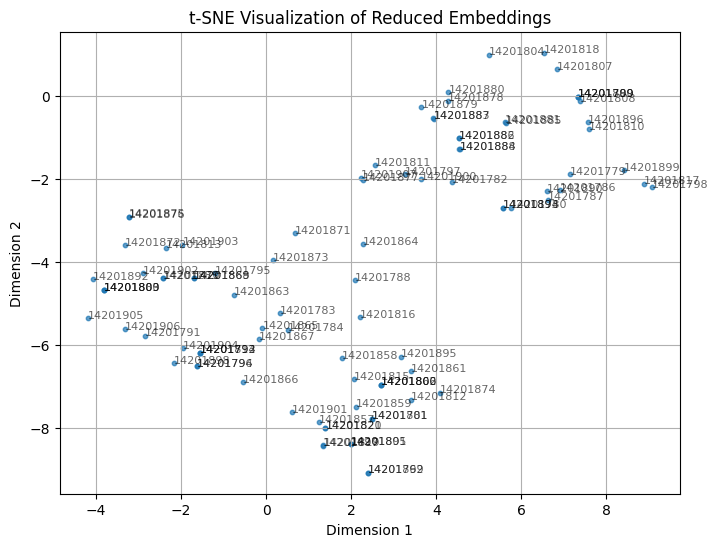

In [10]:
# 임베딩 분포 확인 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 저장된 데이터 로드
data = np.load("reduced_mchapter_embeddings_6.npy", allow_pickle=True).item()

# IDs와 Embeddings 분리
f_mchapter_ids = data['ids']
embeddings = data['embeddings']  # (94, 6)

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], alpha=0.7, s=10)

# 각 점에 중단원 ID 표시 (선택 사항)
for i, txt in enumerate(f_mchapter_ids):
    plt.annotate(txt, (reduced_embeddings_tsne[i, 0], reduced_embeddings_tsne[i, 1]), fontsize=8, alpha=0.6)

plt.title('t-SNE Visualization of Reduced Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()